# Exercise Description

In this exercise, I will be analyzing a training dataset containing dicom lung x-rays in order to detect/predict pneumonia in the lungs. This will be administered by predicting bounding box dimensions around areas of the lungs.  Accompanied with this dataset are two csv files containing the following attributes: 

CSV_1
* patientIds:: Each patientId corresponds to a unique image.
* x-min:: Upper left x-coordinate of the bounding box for patients who do have pneumonia  
* y-min:: Upper left y-coordinate of the bounding box for patients who do have pneumonia 
* width:: The width of the bounding box
* height:: The height of the bounding box 
* Target:: Binary class variable indicating whether this sample has evidence of pneumonia 

CSV_2
* patientIds:: Each patient 
* class:: Detailed class info, categorical variable (Normal, No Lung Opacity/ Not Normal, Lung Opacity) 

In [35]:
import pylab
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.mixture import GaussianMixture

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot, cm
from matplotlib.patches import Rectangle
import pydicom
from pydicom.data import get_testdata_files

from glob import glob
import multiprocessing
import os
import warnings
warnings.filterwarnings('ignore')

### Exploring Training Data

Example of a patient with evidence of Pneumonia


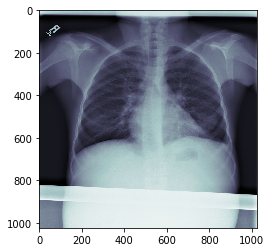

In [11]:
pn_ex = pydicom.dcmread("/Users/nikitathomas/Desktop/stage_2_train_images/0a0f91dc-6015-4342-b809-d19610854a21.dcm")
ax = plt.imshow(pn_ex.pixel_array, cmap=plt.cm.bone) 
print("Example of a patient with evidence of Pneumonia")

Example of a patient without evidence of Pneumonia


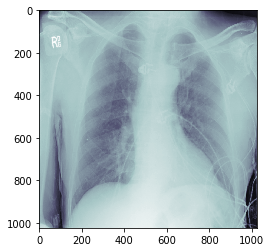

In [12]:
non_pn_ex = pydicom.dcmread("/Users/nikitathomas/Desktop/stage_2_train_images/0a120828-703c-4273-9d62-317dc92c560e.dcm")
plt.imshow(non_pn_ex.pixel_array, cmap=plt.cm.bone) 
print("Example of a patient without evidence of Pneumonia")

In [6]:
df_box = pd.read_csv('/Users/nikitathomas/Desktop/stage_2_train_labels.csv')
print('Number of rows (unique boxes per patient) in main train dataset:', df_box.shape[0])
print('Number of unique patient IDs:', df_box['patientId'].nunique())
df_box.head(6)

Number of rows (unique boxes per patient) in main train dataset: 30227
Number of unique patient IDs: 26684


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Target
0    0.683892
1    0.316108
dtype: float64


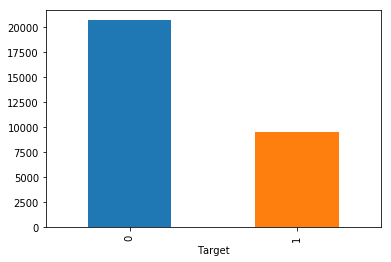

In [15]:
df_box.groupby('Target').size().plot.bar()
print(df_box.groupby('Target').size() / df_box.shape[0])

Above graph shows the class imbalance in this dataset. 

In [16]:
df_aux = pd.read_csv('/Users/nikitathomas/Desktop/stage_2_detailed_class_info.csv')
print('Number of rows in auxiliary dataset:', df_aux.shape[0])
print('Number of unique patient IDs:', df_aux['patientId'].nunique())
df_aux.head(6)

Number of rows in auxiliary dataset: 30227
Number of unique patient IDs: 26684


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


class
Lung Opacity                    0.316108
No Lung Opacity / Not Normal    0.391074
Normal                          0.292818
dtype: float64


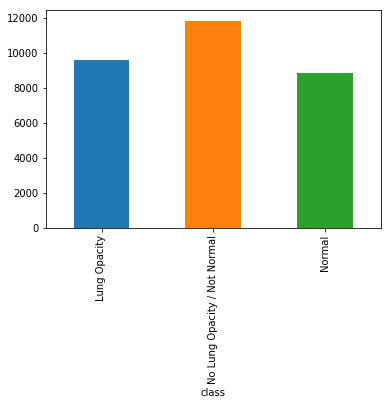

In [17]:
df_aux.groupby('class').size().plot.bar()
print(df_aux.groupby('class').size() / df_aux.shape[0])
assert df_box.loc[df_box['Target']==0].shape[0] == df_aux.loc[df_aux['class'].isin(['Normal', \
    'No Lung Opacity / Not Normal'])].shape[0], 'Number of negative targets does not match between main and auxiliary dataset.'
assert df_box.loc[df_box['Target']==1].shape[0] == df_aux.loc[df_aux['class'] == 'Lung Opacity'].shape[0], \
    'Number of positive targets does not match between main and auxiliary dataset.'

#### Combining both csvs into one dataset

In [18]:
assert df_box['patientId'].values.tolist() == df_aux['patientId'].values.tolist(), 'PatientId columns are different.'
df_train = pd.concat([df_box, df_aux.drop(labels=['patientId'], axis=1)], axis=1)
df_train.head(6)

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity


### Extracting metadata found within dicom files: 

In [19]:
# check that there is an image for each unique patient ID
assert sorted(df_train['patientId'].unique().tolist()) == sorted([f[:-4] for f in os.listdir('/Users/nikitathomas/Desktop/stage_2_train_images')]), \
    'Discrepancy between patient IDs and radiograph images.'

In [20]:
# Example of a patient's metadata 
pId = df_train['patientId'].sample(1).values[0]    
dcmdata = pydicom.read_file('/Users/nikitathomas/Desktop/stage_2_train_images/'+pId+'.dcm')
print(dcmdata)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.7374.1517874331.263614
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: PA'
(0010, 0010) Patient's Name                      PN: '6a41caa1-bf05-4c9e-9021-9b5677fc25fb'
(0010, 0020) Patient ID                          LO: '6a41caa1-bf05-4c9e-9021-9b5677fc25fb'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's

In [25]:
patientIds = df_box.drop_duplicates('patientId', keep = 'first').patientId.tolist()
Sex = []
Age = []
for patientId in patientIds:
    dcm_file = '/Users/nikitathomas/Desktop/stage_2_train_images/%s.dcm' % patientId
    dcm_data = pydicom.read_file(dcm_file)
    Sex.append(dcm_data.PatientSex)
    Age.append(int(dcm_data.PatientAge))

In [42]:
patientInfo = pd.DataFrame({'patientId': patientIds, 'patientSex': Sex, 'patientAge': Age, 'pixel_spacing': float(dcm_data.PixelSpacing[0]), 'mean_black_pixels':np.mean(dcm_data.pixel_array == 0)})
patientAge_count = patientInfo['patientAge'].value_counts().sum()
patientSex_count = patientInfo['patientSex'].value_counts().sum()
patient_count = patientInfo['patientId'].value_counts().sum()

print("Total number of patientId :: %i" % patient_count )
print("Total number of patients with Non null patientSex :: %i " % patientSex_count )
print("Total number of patients with Non null patientAge :: %i " %  patientAge_count )
print("Number of missing values to be imputed for the first field :: %i " % (patient_count - patientSex_count) )
print("Number of missing values to be imputed for the second field :: %i " % (patient_count - patientAge_count) )

Total number of patientId :: 26684
Total number of patients with Non null patientSex :: 26684 
Total number of patients with Non null patientAge :: 26684 
Number of missing values to be imputed for the first field :: 0 
Number of missing values to be imputed for the second field :: 0 


In [28]:
patientInfo = patientInfo.set_index('patientId').join(df_box.set_index('patientId'))[['patientSex', 'patientAge', 'Target']]
patientInfo.reset_index(inplace=True)
patientInfo.head()

,patientId,patientSex,patientAge,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,F,51,0
1,000924cf-0f8d-42bd-9158-1af53881a557,F,19,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,1
3,000db696-cf54-4385-b10b-6b16fbb3f985,F,25,1
4,000fe35a-2649-43d4-b027-e67796d412e0,M,40,1


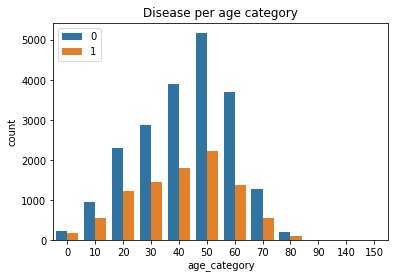

In [29]:
patientInfo['age_category'] = (patientInfo['patientAge'] // 10) * 10
ax = sns.countplot(x="age_category", hue="Target", data=patientInfo)
ax.set_title('Disease per age category')
ax.legend(title='Disease')
ax.legend()

In [44]:
df_box['aspect_ratio'] = (df_box['width']/df_box['height']) # image width/height = aspect ratio for images 
df_box['area'] = df_box['width'] * df_box['height']

In [50]:
def draw_img(patient_id, title=None):
    dcm_file = '/Users/nikitathomas/Desktop/stage_2_train_images/%s.dcm' % patient_id
    dcm_data = pydicom.read_file(dcm_file)
    plt.imshow(dcm_data.pixel_array)
    if title is not None:
        plt.title(title)

def draw_grid(arr_patients, rows=5, columns=4, titles=None, figsize=(15, 15)):
    fig=plt.figure(figsize=figsize)
    for i in range(1, columns*rows + 1):
        if(i <= len(arr_patients)):
            fig.add_subplot(rows, columns, i)
            if titles is None:
                    draw_img(arr_patients[i - 1])
            else:
                    draw_img(arr_patients[i - 1], title=titles[i - 1])
    plt.show()
    
patients_greater_80 = patientInfo[patientInfo['patientAge']>=80]
patients_less_10 = patientInfo[patientInfo['patientAge']<=10]
patients_mid_age = patientInfo[(patientInfo['patientAge']>=30) & (patientInfo['patientAge']<= 50)]

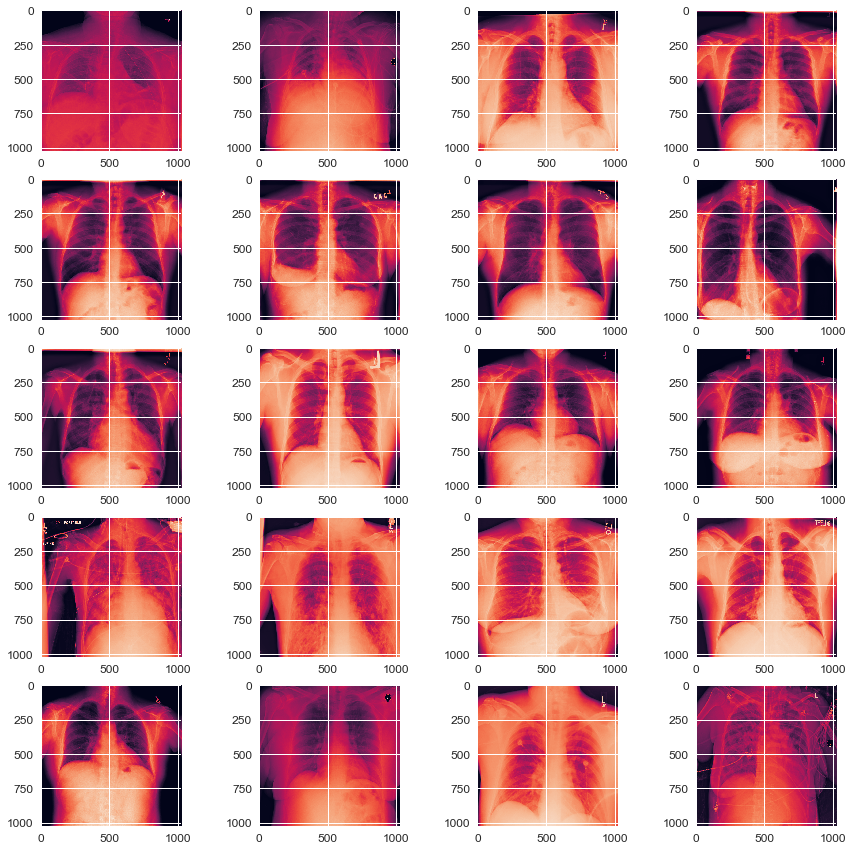

In [51]:
draw_grid(patients_mid_age['patientId'].tolist())

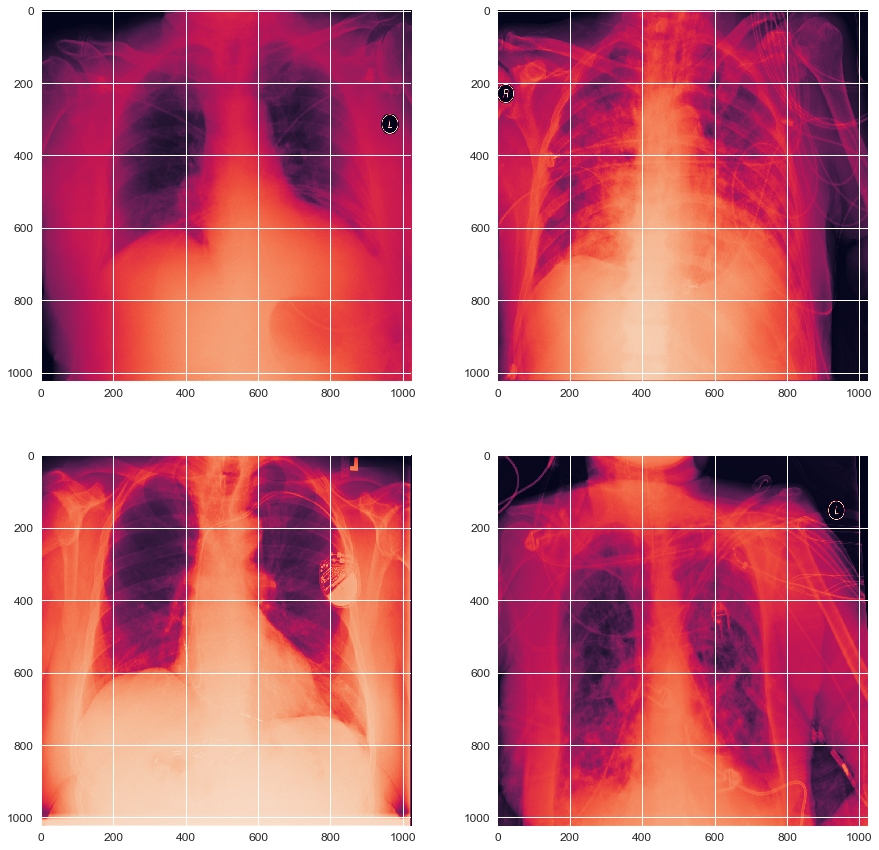

In [52]:
draw_grid(patients_greater_80['patientId'].tolist(), 2, 2)

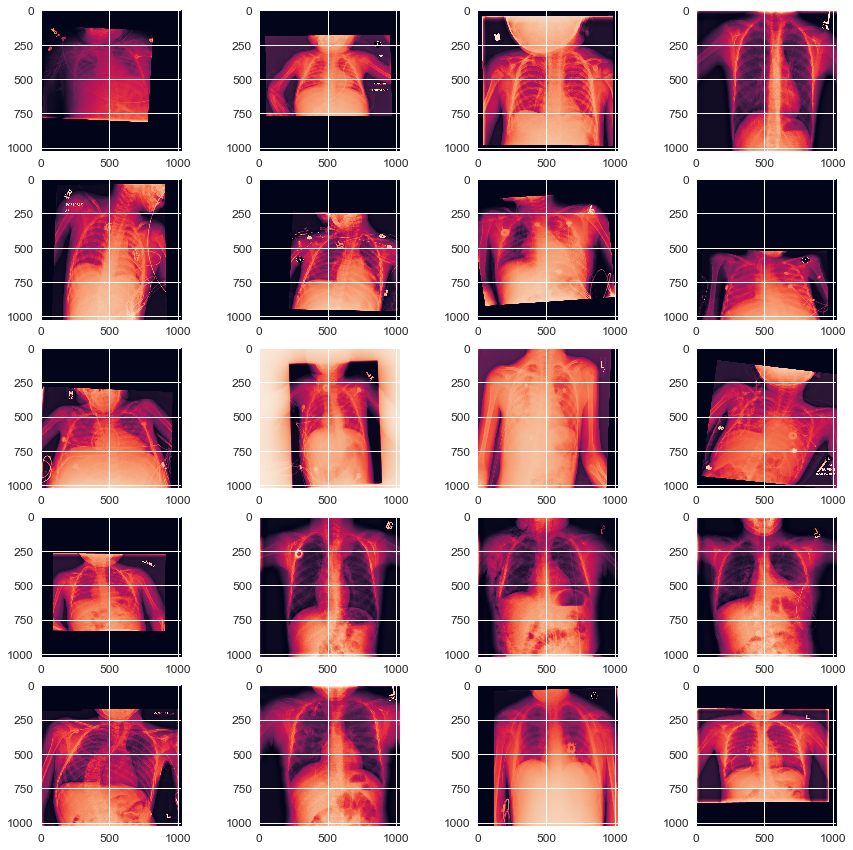

In [53]:
draw_grid(patients_less_10['patientId'].tolist())

## Outlier Detection

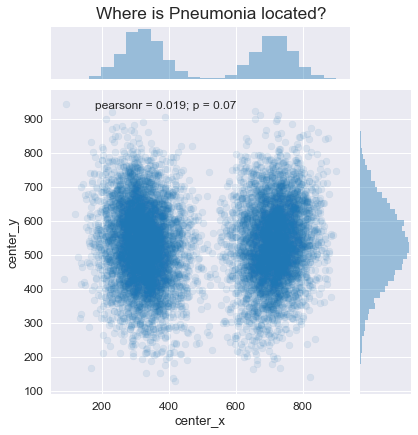

In [37]:
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['lines.linewidth'] = 2.5

centers = (df_box.dropna(subset=['x'])
           .assign(center_x=df_box.x + df_box.width / 2, center_y=df_box.y + df_box.height / 2)) 

## NOTE: x and y coordinates give the top left coordinate and the box is created by the width and heigh values

ax = sns.jointplot("center_x", "center_y", data=centers, alpha=0.1)
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

#### Gaussian Mixture 

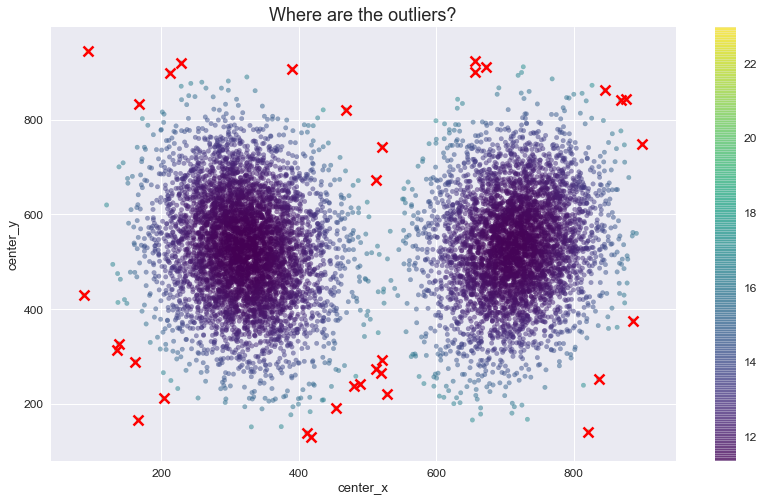

In [38]:
clf = GaussianMixture(n_components=2)
clf.fit(centers[['center_x', 'center_y']])
center_probs = clf.predict_proba(centers[['center_x', 'center_y']])
Z = -clf.score_samples(centers[['center_x', 'center_y']])
outliers = centers.iloc[Z > 17]
fig, ax = plt.subplots()
centers.plot.scatter('center_x', 'center_y', c=Z, alpha=0.5, cmap='viridis', ax=ax)
outliers.plot.scatter('center_x', 'center_y', c='red', marker='x', s=100, ax=ax)
_ = ax.set_title('Where are the outliers?', fontsize=18)

In [41]:
print("Number of outliers:", len(outliers))

Number of outliers: 33


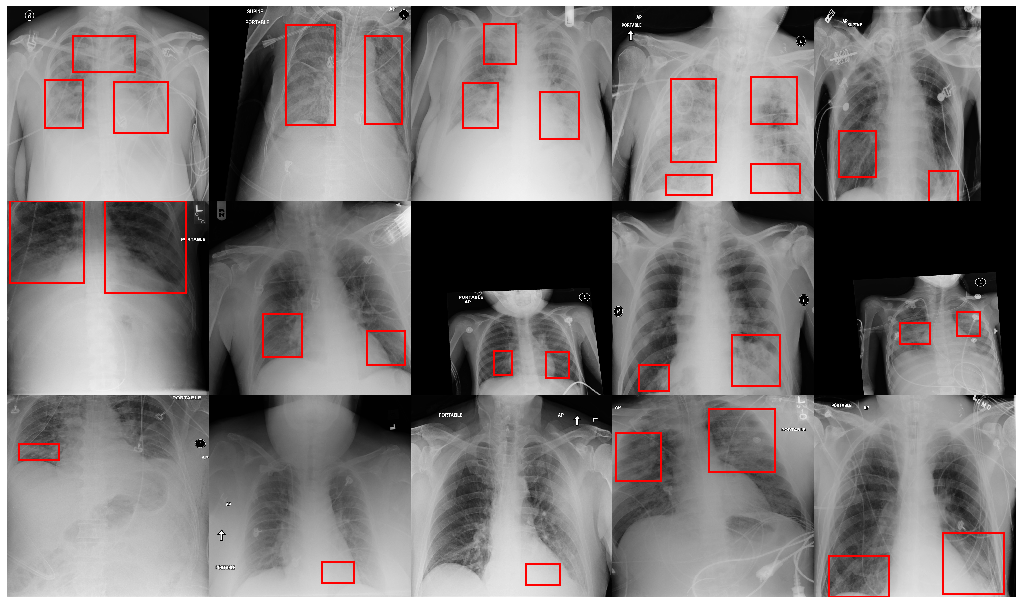

In [55]:
import matplotlib.patches as patches

def get_image(patientId, root_dir='/Users/nikitathomas/Desktop/stage_2_train_images'):
    fn = os.path.join(root_dir, f'{patientId}.dcm')
    dcm_data = pydicom.read_file(fn)
    return dcm_data.pixel_array

def draw_bbs(bbs, ax):
    for bb in bbs.itertuples():
        rect = patches.Rectangle(
            (bb.x, bb.y), bb.width, bb.height,
            linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

def draw_image(img, bbs, ax):
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    if bbs is not None:
        draw_bbs(bbs, ax)

outliers_15 = outliers.drop_duplicates(subset=['patientId']).iloc[:15]
fig, axes = plt.subplots(3, 5)
for row, ax in zip(outliers_15.itertuples(), axes.flatten()):
    img = get_image(row.patientId)
    bbs = df_box.loc[df_box.patientId == row.patientId, ['x', 'y', 'width', 'height']]
    draw_image(img, bbs, ax)
fig.tight_layout(pad=-0.5)